In [1]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns

from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence
sns.set_style('whitegrid')

import matplotlib.font_manager as fm

In [7]:
def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Identify rows with NaN 'Gene Name'
    removed_indices = merged_df[merged_df['Gene Name'].isna()]['Accession'].tolist()

    # Print the original indices that were removed
    print("Original indices removed due to NaN 'Gene Name':", removed_indices)

    # Set 'Gene Name' as the new index and drop the 'Accession' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

In [8]:
P1K_Gene_Presence_Matrix = pd.read_csv("../Data/P1K_Gene_Presence_Matrix.csv", index_col=0)

In [9]:
RegulonDB_TRN = pd.read_csv('../Data/RegulonDB_TRN_C_and_S.csv', index_col = 0)

In [10]:
biocyc_info = pd.read_csv('../Data/biocyc_info.txt', sep="\t")

In [11]:
P1K_Gene_Presence_Matrix = map_accession_to_gene_name(P1K_Gene_Presence_Matrix, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [15]:
P1K_Gene_Presence_Matrix

,Sugar Diacid,Translation,ygdT,OxyR,FlhDC-2,Osmoprotectant,Glutamine,Sialic Acid,yqhI,ROS TALE Amp,...,Tryptophanase,crp KO-2,cyoB/ndh/nuoB KO-2,tpiA KO,Phage Shock,Glyoxylate,CCK-PGI Del,Acetate,Ile/Val,UC-8
Gene Name,,,,,,,,,,,,,,,,,,,,,
thrA,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
thrB,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
thrC,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yaaX,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yaaA,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yneP,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ynfT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yoaL,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
iM_gene = P1K_Gene_Presence_Matrix.loc[P1K_Gene_Presence_Matrix.any(axis=1)]

In [13]:
iM_gene

,Sugar Diacid,Translation,ygdT,OxyR,FlhDC-2,Osmoprotectant,Glutamine,Sialic Acid,yqhI,ROS TALE Amp,...,Tryptophanase,crp KO-2,cyoB/ndh/nuoB KO-2,tpiA KO,Phage Shock,Glyoxylate,CCK-PGI Del,Acetate,Ile/Val,UC-8
Gene Name,,,,,,,,,,,,,,,,,,,,,
thrA,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
thrB,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
thrC,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yaaX,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yaaA,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yneP,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ynfT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yoaL,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
RegulonDB_TRN

,FecI,FliA,RpoD,RpoE,RpoH,RpoN,RpoS,AcrR,Ada,AdiY,...,YefM,YefMB,YgiV,YhaJ,YiaU,YjjQ,YqhC,ZntR,ZraR,Zur
aaeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaeB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaeR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaeX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abgA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
zraP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
zraR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
zraS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import pandas as pd

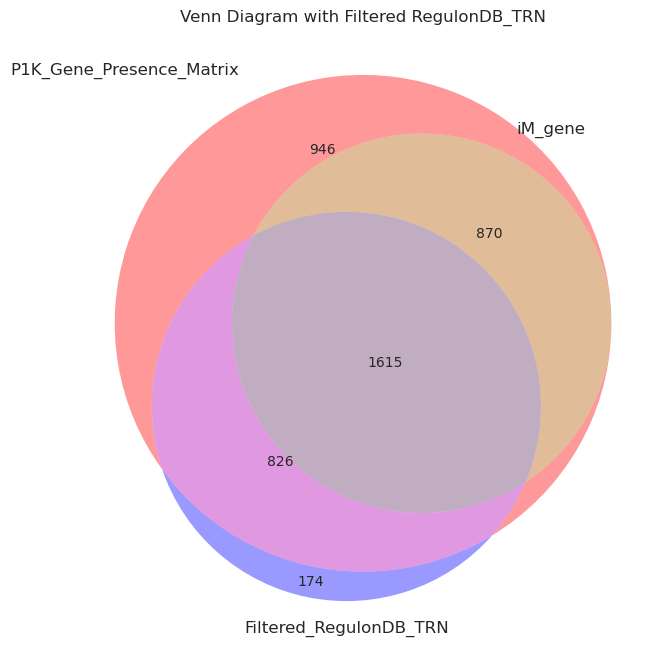

In [40]:
# Step 1: Extract the index values
set1 = set(P1K_Gene_Presence_Matrix.index)
set2 = set(iM_gene.index)
set3 = set(RegulonDB_TRN.index)


# Step 3: Create a new Venn diagram for the filtered data
plt.figure(figsize=(8, 8))
venn3([set1, set2, set(RegulonDB_TRN.index)], 
      ('P1K_Gene_Presence_Matrix', 'iM_gene', 'Filtered_RegulonDB_TRN'))

# Display the plot
plt.title("Venn Diagram with Filtered RegulonDB_TRN")
plt.show()

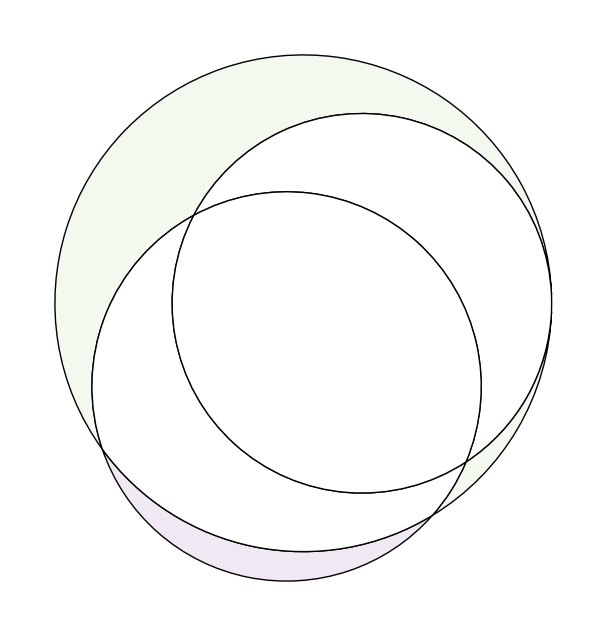

In [38]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Step 1: Extract the index values
set1 = set(P1K_Gene_Presence_Matrix.index)
set2 = set(iM_gene.index)
set3 = set(RegulonDB_TRN.index)

# Step 3: Create a new Venn diagram for all data with improved colors
plt.figure(figsize=(8, 8))
venn = venn3(
    [set1, set2, set3],
    ('', '', ''),  # Remove set labels by passing empty strings
    set_colors=('#F4F9F0', '#FFF7EA', '#F0E9F3')  # Custom colors
)

# Customize the appearance to ensure visibility of all regions
for subset in ('100', '010', '001', '110', '101', '011', '111'):
    patch = venn.get_patch_by_id(subset)
    if patch:
        patch.set_edgecolor('black')  # Add black edge for better distinction
        patch.set_alpha(1.0)          # Remove transparency

# Remove all text (subset labels) by setting them to None
for text in venn.subset_labels:
    if text:
        text.set_text('')  # Remove the subset label text

# Save the figure as SVG without displaying it
plt.savefig("gene_overlap_iM_regulon_P1K.svg", format="svg", bbox_inches='tight')
